In [1]:
!pip install seaborn
!pip install graphviz
!pip install xgboost
!pip install lightgbm

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


## PairPlot, HeatMap

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
iris = sns.load_dataset("iris")

In [4]:
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


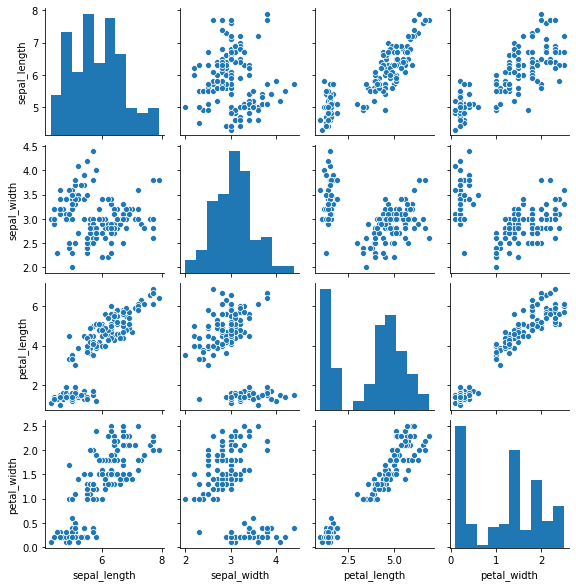

In [5]:
sns.pairplot(iris, height=2)

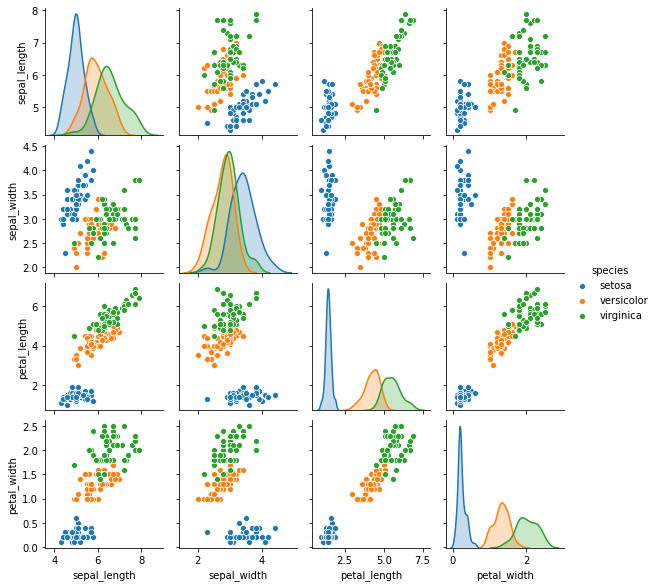

In [6]:
sns.pairplot(iris, hue="species", height=2)

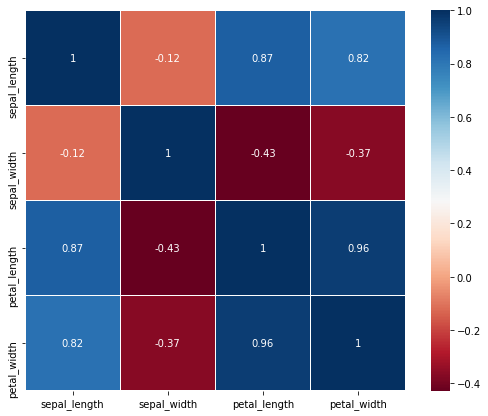

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(9, 7))
sns.heatmap(iris.drop("species", axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [8]:
ttc = sns.load_dataset("titanic")
ttc.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [9]:
for _ in ttc:
    if _ == "sex":
        ttc[_] = ttc['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    if _ == "alone":
        ttc[_] = ttc['alone'].map( {False: 0, True: 1} ).astype(int)
    if _ == "age":
        ttc[_] = ttc['age'].fillna(ttc['age'].median())
drop_elements = ['class', 'who', 'adult_male', 'deck', 'embark_town', 'embarked', 'alive']
ttc = ttc.drop(drop_elements, axis=1)
ttc.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,alone
0,0,3,1,22.0,1,0,7.2500,0
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,1


In [10]:
features = ttc.drop("survived", axis=1)

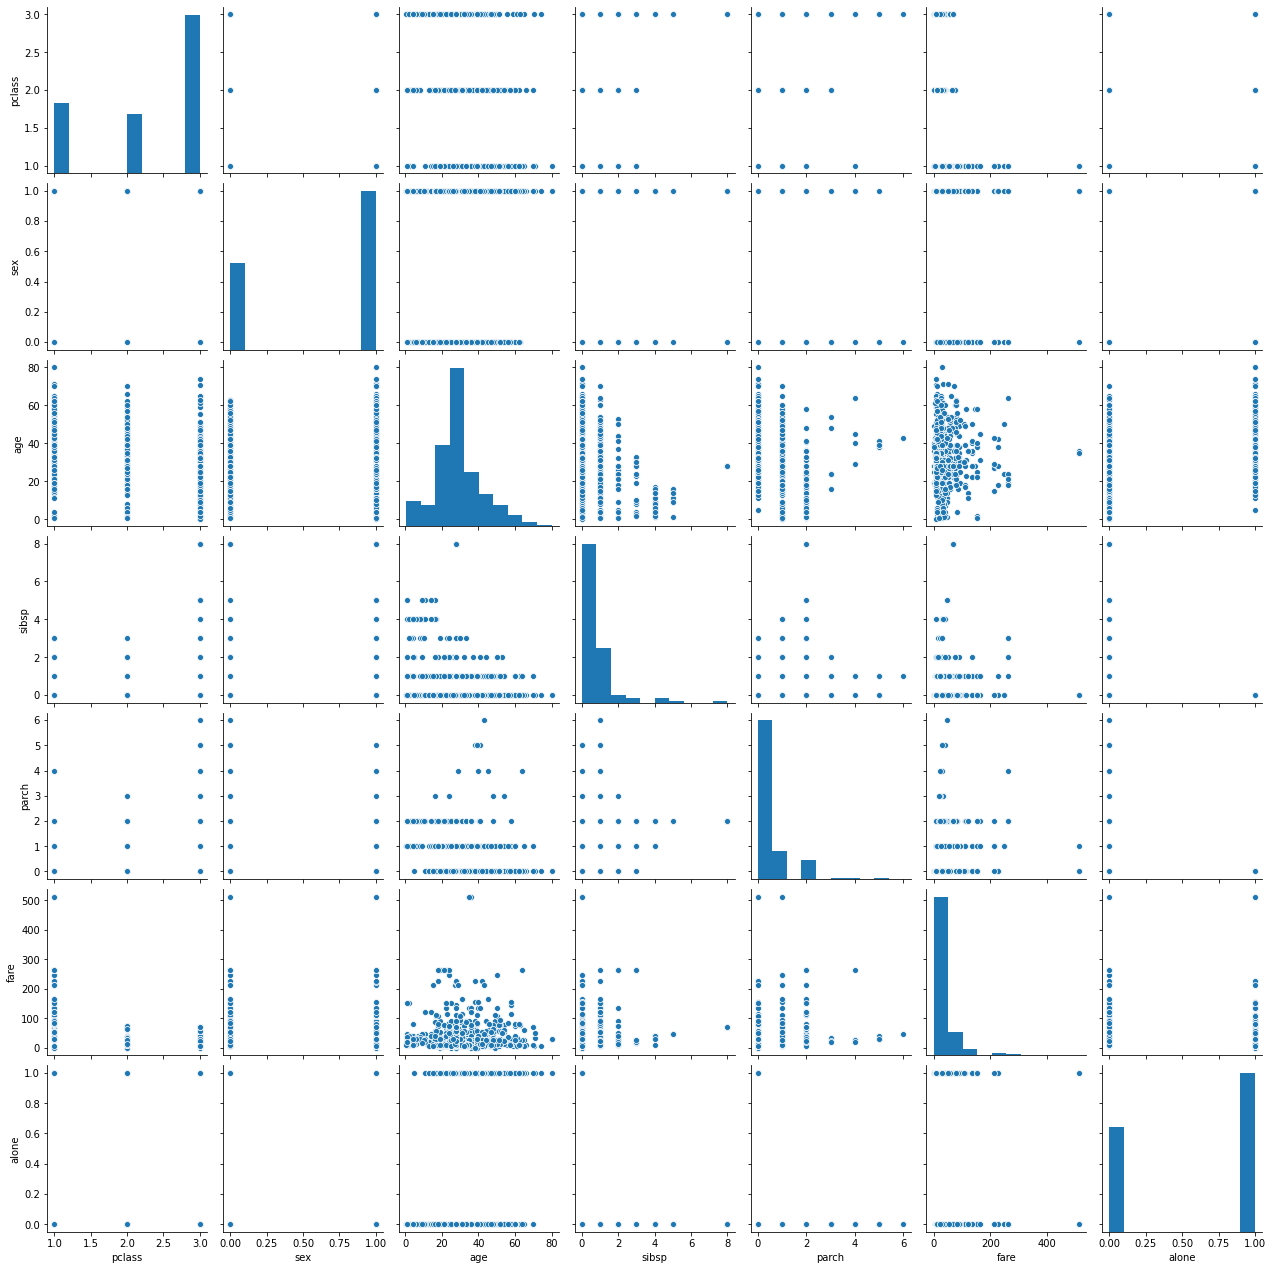

In [11]:
sns.pairplot(features)

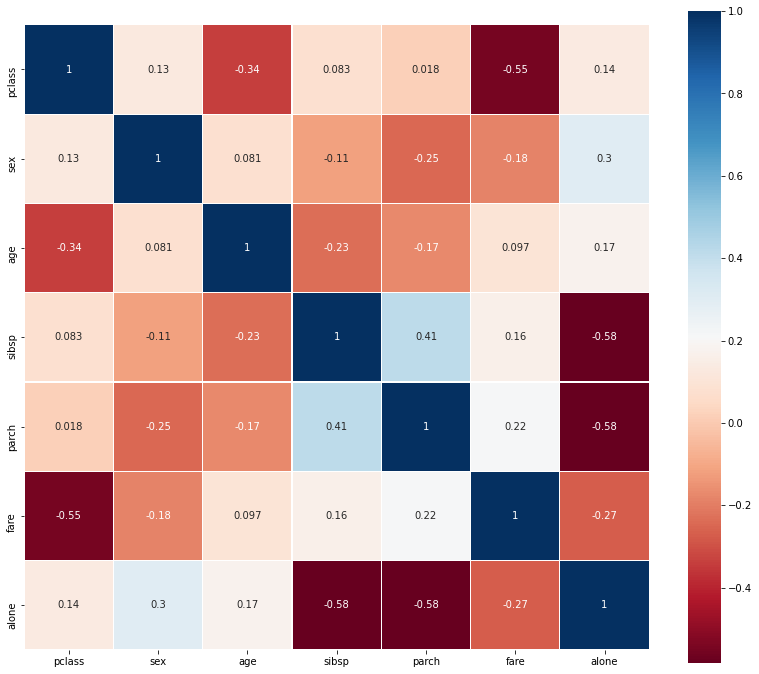

In [12]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
sns.heatmap(features.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## DecisionTree

In [13]:
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

In [14]:
target = ttc["survived"]
features = ttc.drop("survived", axis=1)
features.head(3)

,pclass,sex,age,sibsp,parch,fare,alone
0,3,1,22.0,1,0,7.2500,0
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,1


In [15]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(features, target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

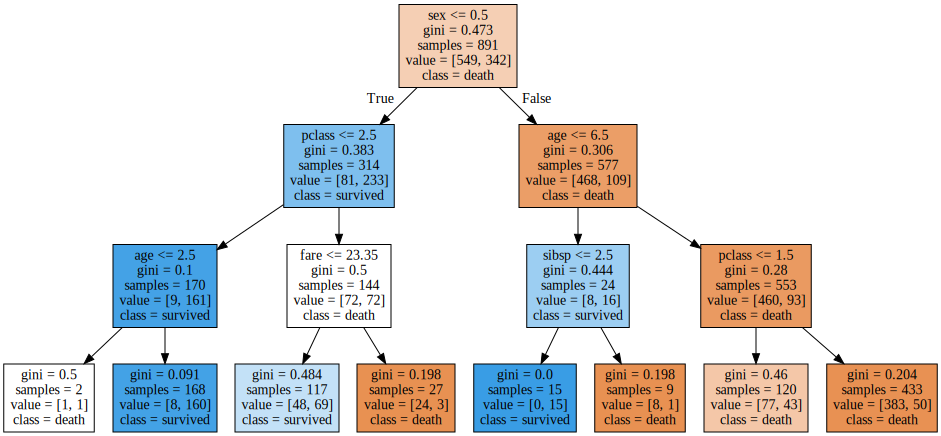

In [16]:
export_graphviz(
    clf,
    out_file='tree.dot',
    class_names=['death', 'survived'],
    feature_names=features.keys(),
    filled=True
)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [17]:
for n, v in zip(features, clf.feature_importances_):
    print(f'importance of {n} is :{v}')

importance of pclass is :0.21352543351233416
importance of sex is :0.6288796382731139
importance of age is :0.061866895093931874
importance of sibsp is :0.04492651373891922
importance of parch is :0.0
importance of fare is :0.05080151938170098
importance of alone is :0.0


### RandomForest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [19]:
train_x, test_x, train_y, test_y = train_test_split(
    features, target, test_size=0.2, shuffle=True)

In [20]:
random_forest = RandomForestClassifier(max_depth=3, n_estimators=30, random_state=42)
random_forest.fit(train_x, train_y)
y_pred = random_forest.predict(test_x)
accuracy_random_forest = accuracy_score(test_y, y_pred)
print('Accuracy: {}'.format(accuracy_random_forest))

Accuracy: 0.7877094972067039


In [21]:
for n, v in zip(features, random_forest.feature_importances_):
    print(f'importance of {n} is :{v}')

importance of pclass is :0.19167166981471534
importance of sex is :0.46962072586209236
importance of age is :0.07544677928335426
importance of sibsp is :0.05024839295243536
importance of parch is :0.02302151005158769
importance of fare is :0.153357150315994
importance of alone is :0.0366337717198208


### xgboost

In [22]:
import xgboost as xgb

In [23]:
param = {
    'max_depth': 3, 
    'eta': 1, 
    'num_class': 2
}
num_round = 10
dtrain = xgb.DMatrix(train_x, label=train_y)
bst = xgb.train(param, dtrain, num_round)

In [24]:
dtest = xgb.DMatrix(test_x)
pred = bst.predict(dtest)
score = accuracy_score(test_y, pred)
print('Accuracy: {0:.4f}'.format(score))

Accuracy: 0.8156


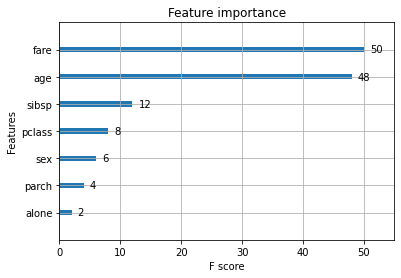

In [25]:
xgb.plot_importance(bst)

### lightGBM

In [26]:
import lightgbm as lgb

In [27]:
train_data = lgb.Dataset(train_x, label=train_y)
eval_data = lgb.Dataset(test_x, label=test_y, reference= train_data)

In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 2,
    'verbose': 2,
}

In [34]:
gbm = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
    num_boost_round=10,
    verbose_eval=5,
)

[5]	valid_0's multi_logloss: 0.520711
[10]	valid_0's multi_logloss: 0.471672


In [35]:
preds = gbm.predict(test_x)

In [36]:
pred = []
for x in preds:
    pred.append(np.argmax(x))
accuracy_score(test_y, pred)

0.7988826815642458

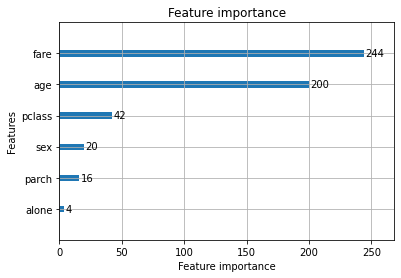

In [37]:
lgb.plot_importance(gbm)